# Load Data

In [1]:
from os import listdir
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filepaths = glob.glob("../data/tidy/acetaminophen/*_events_*.csv")
df = pd.concat(map(pd.read_csv, filepaths))
df["CLINICAL_EVENT_DATETIME"] = pd.to_datetime(df["CLINICAL_EVENT_DATETIME"])
df.index = df["CLINICAL_EVENT_DATETIME"]

/home/brian/anaconda3/envs/tsa_course/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [3]:
apap_daily = df.resample("D").count()[["EVENT_ID"]]
apap_daily.columns = ["Doses"]

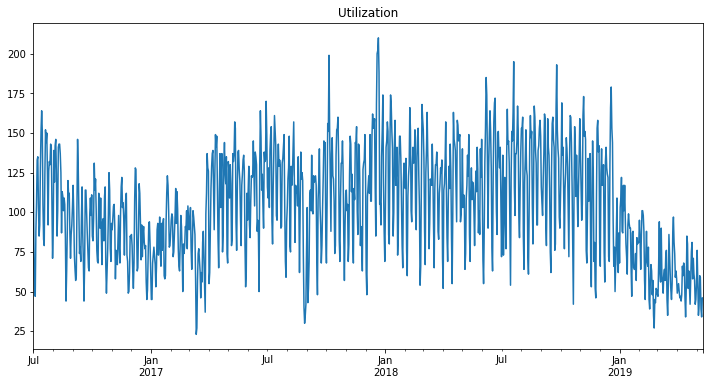

In [4]:
ax = apap_daily.plot(legend=False, figsize=(12, 6), title="Utilization")
ax.autoscale(axis='x',tight=True)
ax.set(xlabel="");

# ACF

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import lag_plot

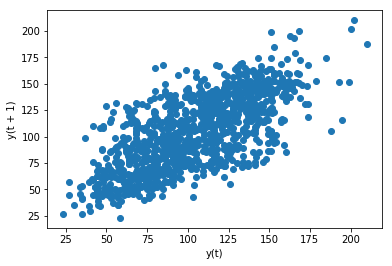

In [6]:
lag_plot(apap_daily["Doses"]);

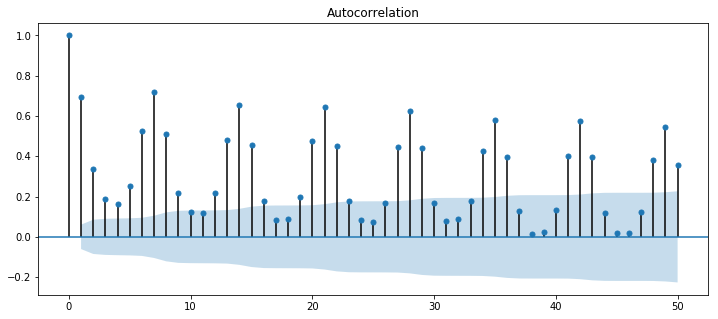

In [7]:
fig, ax = plt.subplots(figsize=(12, 5))

plot_acf(apap_daily["Doses"], lags=50, ax=ax);
#plot_acf(apap_daily);

In [8]:
# data is not stationary; p-value > 0.05
adfuller(apap_daily["Doses"].dropna(), autolag='AIC')[1]

0.2978121675515909

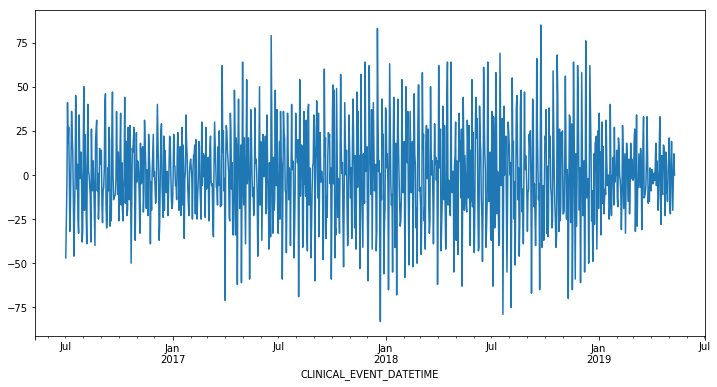

In [9]:
# difference the data to make it stationary
df_diff = apap_daily.copy()
df_diff["Doses"] = diff(apap_daily["Doses"], k_diff=1)
df_diff["Doses"].plot(figsize=(12, 6))

In [10]:
adfuller(df_diff["Doses"].dropna(), autolag='AIC')[1]

3.674029188920869e-19

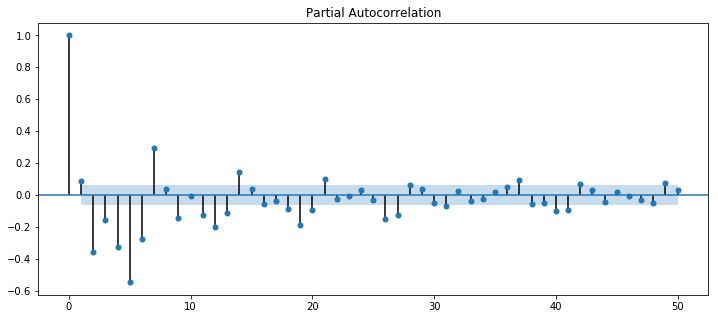

In [11]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(df_diff["Doses"].dropna(), lags=50, ax=ax);

# MLP

In [5]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

Using TensorFlow backend.


In [6]:
n_inputs = 60
n_features = 1
n_valid = 7
n_pred = 30
batch_size = 32

In [7]:
df = apap_daily
#df = df_diff.dropna()
l = len(df) - n_pred
train_set = df.iloc[:l]
train = df.iloc[:l - n_valid]
valid = df.iloc[l - n_inputs - n_valid:l]
test_set = df.iloc[l:]

In [8]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_valid = scaler.transform(valid)
scaled_train_set = scaler.transform(train_set)
scaled_test_set = scaler.transform(test_set)

/home/brian/anaconda3/envs/tsa_course/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [9]:
scaled_train = scaled_train.reshape(scaled_train.shape[0], )
scaled_valid = scaled_valid.reshape(scaled_valid.shape[0], )

In [10]:
gen_train = TimeseriesGenerator(scaled_train, scaled_train, length=n_inputs, batch_size=batch_size)

In [11]:
gen_valid = TimeseriesGenerator(scaled_valid, scaled_valid, length=n_inputs, batch_size=batch_size)

In [12]:
#for i in range(len(gen_valid)):
#    x, y = gen_valid[i]
#    print('%s => %s' % (x, y))

In [13]:
n_nodes = int(len(apap_daily) / (2 * (n_inputs + n_features)))
n_nodes

8

In [14]:
#n_nodes = int(2/3 * (n_inputs + n_features))
#n_nodes

In [15]:
model = Sequential()
model.add(Dense(n_nodes, activation="relu", input_dim=n_inputs))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 488       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit_generator(gen_train, epochs=300, validation_data=gen_valid)

Instructions for updating:
Use tf.cast instead.
Epoch 1/300
31/31 [==============================] - 2s 55ms/step - loss: 0.0516 - val_loss: 0.0037
Epoch 2/300
31/31 [==============================] - 0s 5ms/step - loss: 0.0225 - val_loss: 0.0046
Epoch 3/300
31/31 [==============================] - 0s 7ms/step - loss: 0.0212 - val_loss: 0.0040
Epoch 4/300
31/31 [==============================] - 0s 7ms/step - loss: 0.0203 - val_loss: 0.0040
Epoch 5/300
31/31 [==============================] - 0s 10ms/step - loss: 0.0195 - val_loss: 0.0034
Epoch 6/300
31/31 [==============================] - 0s 6ms/step - loss: 0.0187 - val_loss: 0.0034
Epoch 7/300
31/31 [==============================] - 0s 5ms/step - loss: 0.0181 - val_loss: 0.0034
Epoch 8/300
31/31 [==============================] - 0s 6ms/step - loss: 0.0176 - val_loss: 0.0036
Epoch 9/300
31/31 [==============================] - 0s 7ms/step - loss: 0.0168 - val_loss: 0.0035
Epoch 10/300
31/31 [==============================] - 0s 7m

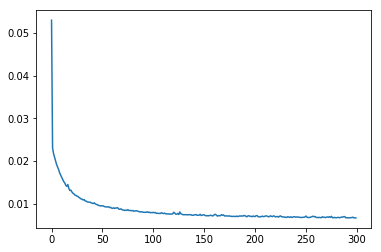

In [17]:
model.history.history.keys()
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [18]:
test_preds = []
first_batch = scaled_train_set[-n_inputs:]
current_batch = first_batch.reshape((1, n_inputs))

for i in range(len(test_set)):
    current_pred = model.predict(current_batch)[0]
    test_preds.append(current_pred[0])
    current_batch = np.append(current_batch[:, 1:], [current_pred], axis=1)

In [19]:
test_preds = np.array(test_preds)
true_preds = scaler.inverse_transform(test_preds.reshape(-1, 1))
test_set["Predictions"] = true_preds

/home/brian/anaconda3/envs/tsa_course/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


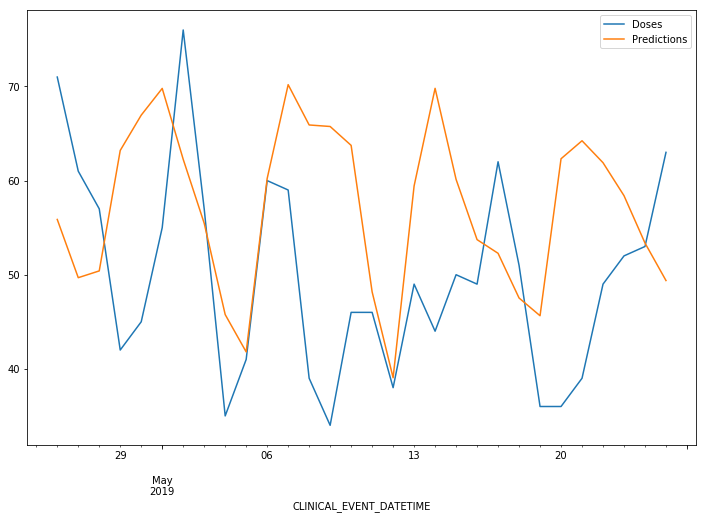

In [20]:
test_set.plot(figsize=(12, 8));

In [21]:
mse_rnn = mean_squared_error(test_set["Doses"], test_set["Predictions"])
rmse_rnn = rmse(test_set["Doses"],  test_set["Predictions"])

print(f'MSE RNN: {mse_rnn:11.10}')
print(f'RMSE RNN: {rmse_rnn:11.10}')

MSE RNN: 228.5810015
RMSE RNN: 15.11889551


# Forecast

In [22]:
n_fcast = 60
new_preds = []
first_batch = scaler.transform(df[-n_inputs:])
current_batch = first_batch.reshape((1, n_inputs))

for i in range(n_fcast):
    current_pred = model.predict(current_batch)[0]
    new_preds.append(current_pred[0])
    current_batch = np.append(current_batch[:, 1:], [current_pred], axis=1)

In [23]:
unscaled_preds = scaler.inverse_transform(np.array(new_preds).reshape(-1, 1))
#undiff_preds = apap_daily["Doses"].iloc[-1] + unscaled_preds.cumsum()
df_preds = pd.DataFrame(unscaled_preds, columns=["Predictions"])
idx = pd.date_range(apap_daily.index[-1] + 1, periods = n_fcast, freq="D")
df_preds.index = idx

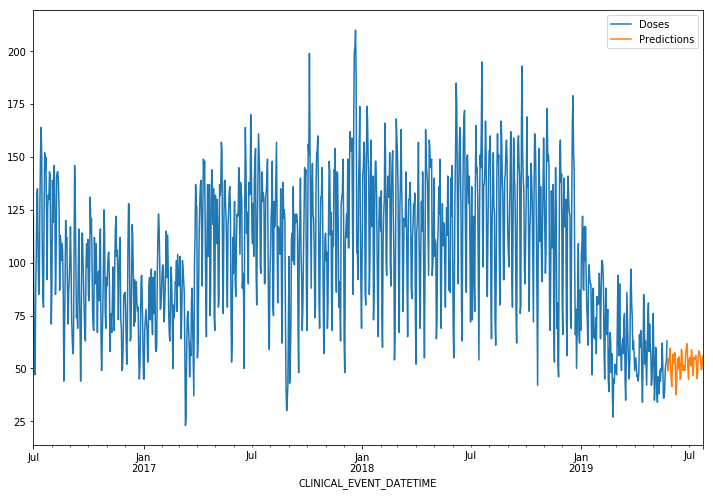

In [24]:
ax = apap_daily["Doses"].plot(figsize=(12, 8), legend=True)
df_preds["Predictions"].plot(legend=True);
ax.autoscale(axis='x',tight=True)

In [25]:
model.save("acetaminophen_mlp_scaled_1-layer.h5")